<a href="https://colab.research.google.com/github/justingardner/tutorials/blob/master/selectivity_and_tolerance_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning goals for the Selectivity and Tolerance notebook. You should have already worked through the [Frequency Freaks](https://colab.research.google.com/drive/1Yxj-Cld8uV3uNQ28WNcgH0udZVqJbdgy?usp=sharing) notebook. After working through this notebook you will be able to...
  * create a LN model of a simple cell
  * create a contrast-energy model of a complex cell
  * create a motion energy model unit similar to Adelson & Bergen
  

In [1]:
# Import libraries that we need
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import imageio as iio
from scipy import interpolate
import math
from scipy import ndimage
from scipy import signal
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from tqdm import tqdm as progressBar

Let's start by defining a few functions from the [frequency freaks](https://colab.research.google.com/drive/1Yxj-Cld8uV3uNQ28WNcgH0udZVqJbdgy) notebook. We will need these to create gabor receptive fields.

In [2]:
# function to make a mesh of x,y points
def getMeshPoints(nPoints):

  # first create a linearly spaced set of x and y points between -1 and 1
  x = np.linspace(-1,1,nPoints)
  y = np.linspace(-1,1,nPoints)

  # keep the extents for use with imshow
  extents = [np.min(x),np.max(x),np.min(y),np.max(y)]

  # now create the mesh of x and y (these will now both be 2D matrices of x and y values)
  x, y = np.meshgrid(x, y, indexing='xy')

  # and return the computed values
  return x, y, extents

# function that makes a gaussian
def makeGaussian(x,y,sigma):
  # there it is!
  gaussian = np.exp(-(x**2+y**2)/(2*sigma**2))
  
  # return 
  return gaussian

# function to make a grating
def makeGrating(x, y, orientation, spatialPhase, spatialFrequency):
  # we wil convert orientation and spatialPhase into radians
  orientation = np.pi*orientation/180
  spatialPhase = np.pi*spatialPhase/180

  # we need to convert spatial frequency into cycles/image
  # remember that we made the extents in getMeshPoints
  # to go from -1 to 1, so we want that to go from -pi to pi
  spatialFrequency = spatialFrequency * np.pi

  # make the grating
  grating = np.cos(spatialFrequency*(x*np.cos(orientation)+y*np.sin(orientation))+spatialPhase)

  # and return
  return grating

Now that we have those functions, lets make a class variable that will contain the necessary things to represent a simple cell - the linear receptive field and the exponent. That is, we will make the init function create a gabor receptive field with a particular spatial frequency, orientation and keep a field that tells what the static output non-linearity is. You know from the [FrequencyFreak](https://colab.research.google.com/drive/1Yxj-Cld8uV3uNQ28WNcgH0udZVqJbdgy)s notebook how to do this from the above functions. Yes?

In [3]:
class simpleCell:
  def __init__(self,meshsize, orientationPreference, spatialPhase, spatialFrequencyPreference, exponent):
    # keep the meshsize
    self.meshsize = meshsize
    
    # first make a mesh of x,y points
    self.x, self.y, self.extents = getMeshPoints(meshsize)

    # compute the grating needed
    grating = makeGrating(self.x, self.y, orientationPreference, spatialPhase, spatialFrequencyPreference)

    # compute the gaussian (we fix the size here, but of course that could be a passed
    # in parameter)
    gaussian = makeGaussian(self.x, self.y, 0.2)

    # now we can make the gabor receptive field
    self.linearRF = grating * gaussian

    # the exponent is just something we store
    self.exponent = exponent

Let's test it to see if generates what we want it to, by creating a simpleCell and displaying it's receptive field.

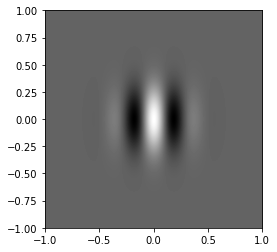

In [4]:
# let's use the following meshsize in all these simulations
meshsize = 513

# create the simple cell
s = simpleCell(meshsize, 0, 0, 5, 2)

# display the receptive field
plt.imshow(s.linearRF,cmap='gray',extent=s.extents)

Ok, your turn. Create a quadrature pair of simple cells like we discussed in class. Display their receptive fields to make sure they look right.

Now, let's write a function that will compute the simple cell response to any stimulus image. 

In [5]:
#function to compute the simple cell response
def computeSimpleCellResponse(simpleCell, stimulus):
  # well, the first step is to apply the linear receptive field
  # which means to take the dot product of the linear receptive field
  # and the stimulus. Note, I don't understand what numpy's dot product
  # does in 2D - so maybe there is a better way to write this. Instead
  # I'm going to go really basic here. Take the element-wise multiplication
  # of stimulus and RF and then add that all up together
  response = simpleCell.linearRF * stimulus
  response = np.sum(response)

  # since the units of the output are aribtrary, let's
  # make them a bit more intepretable where 1 would be the
  # maximum possible reponse of the RF with it's most preferred
  # stimulus. What is the most preferred stimulus, well the one
  # that exactly matches the RF!
  maxResponse = simpleCell.linearRF * simpleCell.linearRF
  maxResponse = np.sum(maxResponse)

  # now normalize by this maximum response
  response = response / maxResponse

  # now we apply a threshold
  if response<0:
    response = 0
  
  # and apply the static non-linearity
  response = response**simpleCell.exponent
  
  # and return, couldn't be simpler, no pun intended. really.
  return response

Ok, now let's write a little function to generate a vertical bar stimulus

Text(0, 0.5, 'Y position')

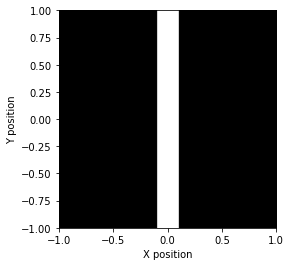

In [6]:
def makeVerticalBarStimulus(meshsize, barPosition, barWidth, barLuminance):
  # get mesh points
  x, y, extents = getMeshPoints(meshsize)
  
  # the stimulus image will have 1 = white, 0 = gray -1 = black
  stimImage = np.zeros((meshsize, meshsize))

  # let's make it have a vertical bar in it - the barLuminance parameter controls
  # whether it is white or black 
  stimImage[np.nonzero(np.logical_and(x > barPosition-barWidth/2, x < barPosition+barWidth/2))] = barLuminance

  # and return the stimImage
  return stimImage

# ok, let's test to see if it works, make a vertical
# bar in the center of the stimulus that is white
stimImage = makeVerticalBarStimulus(meshsize, 0, 0.2, 1)

# and display to make sure we have the right thing
plt.imshow(stimImage,cmap='gray',extent=s.extents)
plt.xlabel('X position')
plt.ylabel('Y position')


Got it? Ok. Let's plot a tuning function. In this case, let's plot the tuning of the RF with respect to the position of the bar. We will make a function that computes the response to vertical bars at different x locations.

Text(0, 0.5, 'Response')

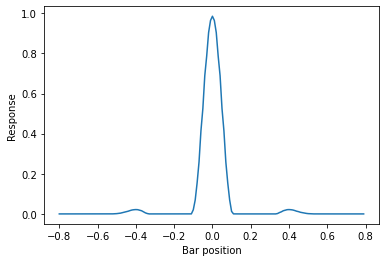

In [7]:
# create a function to compute the response to a vertical
# bar at different locations in the receptive field
def computeResponseToVerticalBar(simpleCell, barLuminance):

  # init response array
  r = []

  # bar positions to examine simple cell response over
  barPositions = np.arange(-0.8, 0.8, 0.01) 

  # now for each bar position, compute the simple cell response
  for barLoc in barPositions:
    # Get the stimulus image using the function from above
    stimImage = makeVerticalBarStimulus(meshsize, barLoc, 0.2, barLuminance)

    # compute response
    r.append(computeSimpleCellResponse(simpleCell, stimImage))

  # return values
  return barPositions, np.array(r)

# now compute the response for the receptive field we created above
# we set the barLuminance to 1 to do a bright bar
barPositions, r = computeResponseToVerticalBar(s,1)

# plot the response
plt.plot(barPositions,r)
plt.xlabel('Bar position')
plt.ylabel('Response')

Ok, now we can compute the response of a single simple cell for different bar positions. Note that the response is not uniform across the receptive field - i.e. the simple cell only responds to the bar at a position it which it aligns with the excitatory or on part of the receptive field. What happens, if we put on a dark bar at different positions across the receptive field. What would it look like?

Text(0, 0.5, 'Response')

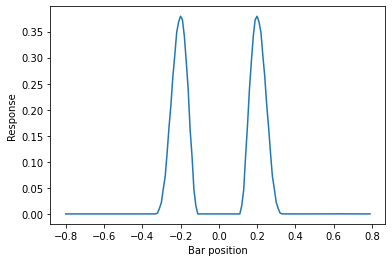

In [8]:
# compute the response to a dark bar
barPositions, r = computeResponseToVerticalBar(s,-1)

# plot the response
plt.plot(barPositions,r)
plt.xlabel('Bar position')
plt.ylabel('Response')

Is that what you expected? I hope so. Now, let's try to make a cell (complex cell) that will respond to a bar with a positive response across the whole receptive fields. Ok, one point we have to take care of. We didn't talk about this in class, but note that the simple cell we have made applies "half-squaring" to the output. That means it thresholds at 0 and sets any negative values to 0 and then squares. The upshot of this is that  the cell can not respond negatively. This is actually fairly accurate as cortical cells (as opposed to retinal ganglion cells in the Enroth-Cugell study) typically have low baseline firing. That means, that they have very little negative range - they cant suppress their baseline firing rate below 0 (after all it makes no sense to say that a neuron is firing less than 0 spikes/sec, right?). So if it's baseline is near 0, then it only signals positive responses, and nothing about negative responses. Look at the graphs above and confirm that this is true. So, how do we fix this? Simple. We just have two simple cells that have tuning that is 180 degrees out of phase with each other. One simple cell gives the positive response and one simple cell gives the negative response - i.e. responds in the dark regions of the other cell. By combining those cells we get a combined response that responds to postivie and negative luminance. Here's some code that implements that idea.

Text(0, 0.5, 'Response')

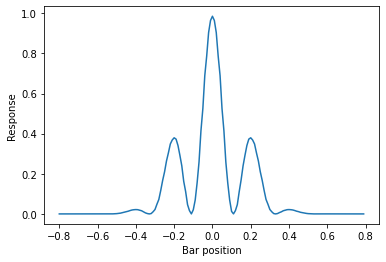

In [9]:
# create a simple cell
s1positive = simpleCell(meshsize,0,0,5,2)

# now create one with the opposite phase (i.e. 180 degrees out of phase)
s1negative = simpleCell(meshsize,0,180,5,2)

# now compute the response of both to bar above
barPosition, s1positiveResponse = computeResponseToVerticalBar(s1positive,1)
barPosition, s1negativeResponse = computeResponseToVerticalBar(s1negative,1)

# add them together
s1response = s1positiveResponse + s1negativeResponse

# and plot
plt.plot(barPosition,s1response)
plt.xlabel('Bar position')
plt.ylabel('Response')

Ok, half way there. We have one half of the quadrature phase. Now you do the rest. Compute a response that is in quadrature phase and add it to what you have here. Then you should have a complex cell that responds positively throughout the receptive field.

Text(0, 0.5, 'Response')

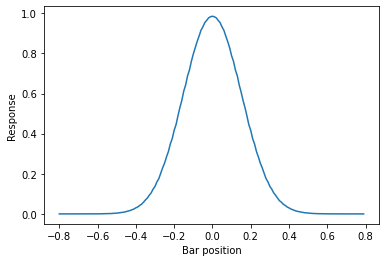

In [10]:
# create a simple cell
s2positive = simpleCell(meshsize,0,90,5,2)

# now create one with the opposite phase (i.e. 180 degrees out of phase)
s2negative = simpleCell(meshsize,0,270,5,2)

# make a function to compute 
barPosition, s1positiveResponse = computeResponseToVerticalBar(s1positive,1)
barPosition, s1negativeResponse = computeResponseToVerticalBar(s1negative,1)
barPosition, s2positiveResponse = computeResponseToVerticalBar(s2positive,1)
barPosition, s2negativeResponse = computeResponseToVerticalBar(s2negative,1)

# add them together and you should get a complex cell
complexResponse = (s1positiveResponse+s1negativeResponse) + (s2positiveResponse+s2negativeResponse)

# and plot
plt.plot(barPosition,complexResponse)
plt.xlabel('Bar position')
plt.ylabel('Response')

The complex cell should also give the same response to a dark bar as it does to a light bar. Test that!

Now, let's put the above into a class so that we can test the complex cell's behavior to any stimulus we like.

In [11]:
# class for a complex cell
class complexCell:
  def __init__(self, meshsize, orientationPreference, spatialFrequencyPreference):
    # keep the meshsize
    self.meshsize = meshsize
    
    # first make a mesh of x,y points
    self.x, self.y, self.extents = getMeshPoints(meshsize)

    # create the four simple cells that are needed 
    self.s000 = simpleCell(meshsize,orientationPreference,0,spatialFrequencyPreference,2)
    self.s090 = simpleCell(meshsize,orientationPreference,90,spatialFrequencyPreference,2)
    self.s180 = simpleCell(meshsize,orientationPreference,180,spatialFrequencyPreference,2)
    self.s270 = simpleCell(meshsize,orientationPreference,180,spatialFrequencyPreference,2)

# and a function that can be used to compute the response of a complex cell
def computeComplexCellResponse(complexCell, stimulus):
  # compute the response to each sub-field
  r000 = computeSimpleCellResponse(complexCell.s000, stimulus)
  r090 = computeSimpleCellResponse(complexCell.s090, stimulus)
  r180 = computeSimpleCellResponse(complexCell.s180, stimulus)
  r270 = computeSimpleCellResponse(complexCell.s270, stimulus)

  # sum together and normalize so that the maximum response is 1
  r = (r000+r090+r180+r270)/4

  # add that all together and return
  return r


Make sense? Now let's see how the complex cell behaves as a function of orientation

Text(0, 0.5, 'Response')

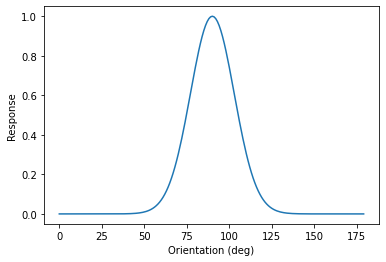

In [12]:
#create a complex cell with orientation preference of 90 and spatial frequency preference of 5 cycles per image
c = complexCell(meshsize, 90, 5)

# init response array
r = []

# loop over orientations
orientations = range(0,180,1)
for orientation in orientations:
  # make a grating of the appropraite orientation
  stimulus = makeGrating(c.x, c.y, orientation, 0, 5)

  # compute complex cell response
  r.append(computeComplexCellResponse(c, stimulus))

# convert to array
r = np.array(r)

# plot
plt.plot(orientations,r)
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')

Ok, now let's add time into this whole business. Let's make a motion-energy model like in the Adelson & Bergen paper. We will use gabor filters as the spatial component like above (in the paper they actually use 2nd and 3rd derivatives of Gaussians - which have a similar shape to them). Let's start with creating the temporal filters using equation 1. Check to make sure that what is plotted here resembles what they have in Fig 10b

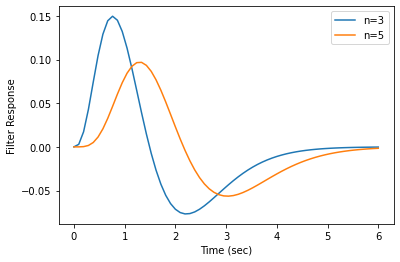

In [13]:
def makeTemporalFilter(t,n,k):
  # equation 1 from Adelson & BErgen
  return ((k * t)**n) * np.exp(-k * t)*((1/math.factorial(n)) - ((k*t)**2)/math.factorial(n+2))

# compute for 10 seconds
nTimePoints = 64
t = np.linspace(0,6,nTimePoints)

# make the two temporal filters
t1 = makeTemporalFilter(t,3,3)
t2 = makeTemporalFilter(t,5,3)

# and plot for different exponent values
plt.plot(t,t1)
plt.plot(t,t2)
plt.xlabel('Time (sec)')
plt.ylabel('Filter Response')
plt.legend(('n=3','n=5'))

Now let's make two quadrature pair gabor spatial filters. This should look like Fig 10a

Text(0, 0.5, 'Response')

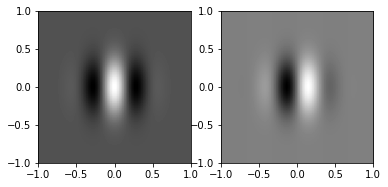

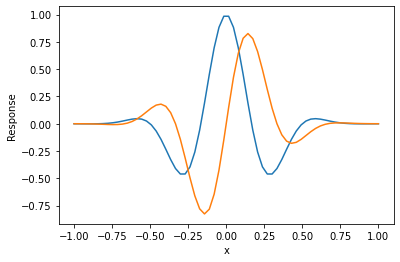

In [14]:
# make two gabors
meshsize = 64
x, y, extents = getMeshPoints(meshsize)
orientation = 0
spatialFrequency = 3
s1 = makeGaussian(x,y,0.25) * makeGrating(x, y, orientation, 0, spatialFrequency)
s2 = makeGaussian(x,y,0.25) * makeGrating(x, y, orientation, -90, spatialFrequency)

# plot to make sure
plt.subplot(121)
plt.imshow(s1,cmap='gray',extent=extents)
plt.subplot(122)
plt.imshow(s2,cmap='gray',extent=extents)

# we can also plot a cross section through the middle
plt.figure()
plt.plot(x[int(meshsize/2),:],s1[int(meshsize/2),:])
plt.plot(x[int(meshsize/2),:],s2[int(meshsize/2),:])
plt.xlabel('x')
plt.ylabel('Response')


Now we make each combination of spatial and temporal filters. These will be space/time separable filters as shown in 10c.

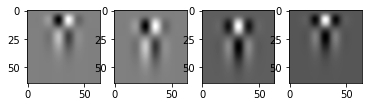

In [15]:
# first let's repeat that spatial filter along the time axis.
# that is, we are just going to take the spatial filter and
# copy it for every time point
s1t1 = np.repeat(s1[:, :, np.newaxis], nTimePoints, axis=2)
s1t2 = np.repeat(s1[:, :, np.newaxis], nTimePoints, axis=2)
s2t1 = np.repeat(s2[:, :, np.newaxis], nTimePoints, axis=2)
s2t2 = np.repeat(s2[:, :, np.newaxis], nTimePoints, axis=2)

# maybe there is a faster python way to do this, but I'm
# just going to loop here and multiply the spatial images
# by the temporal response functions
for i in range(0,nTimePoints):
  s1t1[:,:,i] = s1t1[:,:,i]*t1[i]
  s1t2[:,:,i] = s1t2[:,:,i]*t2[i]
  s2t1[:,:,i] = s2t1[:,:,i]*t1[i]
  s2t2[:,:,i] = s2t2[:,:,i]*t2[i]

# ok, make the plots to see if everything worked correctly
plt.subplot(141)
plt.imshow(s2t1[int(meshsize/2),:,:].T,cmap='gray')
plt.subplot(142)
plt.imshow(s2t2[int(meshsize/2),:,:].T,cmap='gray')
plt.subplot(143)
plt.imshow(s1t2[int(meshsize/2),:,:].T,cmap='gray')
plt.subplot(144)
plt.imshow(s1t1[int(meshsize/2),:,:].T,cmap='gray')

Now make the sum and difference filters. Compare to Fig 10c, bottom row.

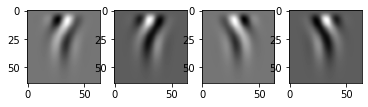

In [16]:
# take the sums and differences of the above
f1 = s2t1+s1t2
f2 = s1t1-s2t2
f3 = s1t2-s2t1
f4 = s1t1+s2t2

# And display
plt.subplot(141)
plt.imshow(f1[int(meshsize/2),:,:].T,cmap='gray')
plt.subplot(142)
plt.imshow(f2[int(meshsize/2),:,:].T,cmap='gray')
plt.subplot(143)
plt.imshow(f3[int(meshsize/2),:,:].T,cmap='gray')
plt.subplot(144)
plt.imshow(f4[int(meshsize/2),:,:].T,cmap='gray')

Ok. Now that we can create the filters, let's build a class to do all of this by copying the code from above. 

In [17]:
# first let's delete the variables made above to free up RAM
del s1, s2, s1t1, s1t2, s2t1, s2t2, f1, f2, f3, f4

In [18]:
class motionEnergyModel:
  def __init__(self, meshsize, nTimePoints):
    # keep the meshsize and nTimePoints
    self.meshsize = meshsize
    self.nTimePoints = nTimePoints
    
    # make two temporal filters
    # compute for 6 seconds
    self.t = np.linspace(0,6,nTimePoints)

    def makeTemporalFilter(t,n,k):
      # equation 1 from Adelson & BErgen
      return ((k * t)**n) * np.exp(-k * t)*((1/math.factorial(n)) - ((k*t)**2)/math.factorial(n+2)) 

    # make the two temporal filters
    t1 = makeTemporalFilter(self.t,3,3)
    t2 = makeTemporalFilter(self.t,5,3)

    # make two spatial filters
    x, y, extents = getMeshPoints(meshsize)
    orientation = 0
    spatialFrequency = 3
    s1 = makeGaussian(x,y,0.25) * makeGrating(x, y, orientation, 0, spatialFrequency)
    s2 = makeGaussian(x,y,0.25) * makeGrating(x, y, orientation, -90, spatialFrequency)
    plt.imshow(s1,cmap='gray')

    # first let's repeat that spatial filter along the time axis.
    # that is, we are just going to take the spatial filter and
    # copy it for every time point
    s1t1 = np.repeat(s1[:, :, np.newaxis], nTimePoints, axis=2)
    s1t2 = np.repeat(s1[:, :, np.newaxis], nTimePoints, axis=2)
    s2t1 = np.repeat(s2[:, :, np.newaxis], nTimePoints, axis=2)
    s2t2 = np.repeat(s2[:, :, np.newaxis], nTimePoints, axis=2)

    # maybe there is a faster python way to do this, but I'm
    #just going to loop here (I miss matlab ;( ))
    for i in range(0,nTimePoints):
      s1t1[:,:,i] = s1t1[:,:,i]*t1[i]
      s1t2[:,:,i] = s1t2[:,:,i]*t2[i]
      s2t1[:,:,i] = s2t1[:,:,i]*t1[i]
      s2t2[:,:,i] = s2t2[:,:,i]*t2[i]

    # make sum and differences
    self.f1 = s2t1+s1t2
    self.f2 = s1t1-s2t2
    self.f3 = s1t2-s2t1
    self.f4 = s1t1+s2t2

Now make a motion energy model and plot its filters to make sure everything is working

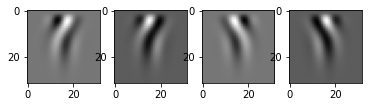

In [19]:
# make with a small number of mesh / time points to make it easier to calculate the response
meshsize = 32
nTimePoints = 32
m = motionEnergyModel(meshsize, nTimePoints)

# display the filters
plt.figure
plt.subplot(141)
plt.imshow(m.f1[int(meshsize/2),:,:].T,cmap='gray')
plt.subplot(142)
plt.imshow(m.f2[int(meshsize/2),:,:].T,cmap='gray')
plt.subplot(143)
plt.imshow(m.f3[int(meshsize/2),:,:].T,cmap='gray')
plt.subplot(144)
plt.imshow(m.f4[int(meshsize/2),:,:].T,cmap='gray')


Now we write a function to compute the response of the motion energy model like what we have done above with simple and complex cells.

In [26]:
def computeMotionEnergyModelResponse(m, stimulus):
  #first we need to make sure that the dimensions of our filters 
  # match the dimensions of the stimulus - in particular the length 
  # in time
  if m.nTimePoints != stimulus.shape[2]:
    print('must do')
  
  # compute the convolution of the filters with the stimulus
  r1 = signal.fftconvolve(stimulus,m.f1,mode='same')
  r2 = signal.fftconvolve(stimulus,m.f2,mode='same')
  r3 = signal.fftconvolve(stimulus,m.f3,mode='same')
  r4 = signal.fftconvolve(stimulus,m.f4,mode='same')

  # and then square and sum each quadrature component
  d1 = (r1**2) + (r2**2)
  d2 = (r3**2) + (r4**2)

  # and take the difference - this is the motion opponency part
  return d1 -d2

Now we are in business. Generate a stimulus, and pass it to the motion energy model to see what response you get. Note that the output is 3D - as the motion energy model is convolved over all of x and y (think - there is a filter at each location in the visual field analyzing the motion) and the output is a function of time where a postive output (white) means rightwards motion and negative output (black) means leftwards motion. Grey means there is no motion detected. Note that there are some edge effects in the output 

[]

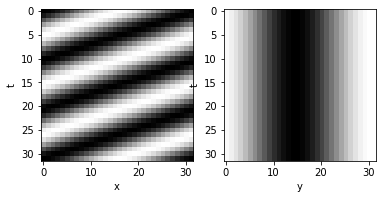

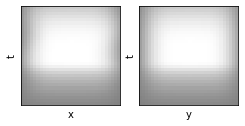

In [21]:
# get x,y points to make stimuli
x, y, extents = getMeshPoints(meshsize)

# init stimulus
stimulus = np.zeros((meshsize,meshsize,nTimePoints))

## Uncomment / comment lines here to try different stimuli
##
# temporal frequency grating
tf = 1
stimulus = np.zeros((meshsize,meshsize,nTimePoints))
for t in range(0,nTimePoints):
  stimulus[:,:,t] = makeGrating(x, y, 0, tf * 360 * (t / nTimePoints), 3)

# rightwards motion of a bar
#for t in range(0,nTimePoints):
#  stimulus[:,:,t] = makeVerticalBarStimulus(meshsize, 0.8 - 1.6*t/nTimePoints , 0.2, -1)

# leftwards motion of a bar
#for t in range(0,nTimePoints):
#  stimulus[:,:,t] = makeVerticalBarStimulus(meshsize, -0.8 + 1.6*t/nTimePoints , 0.2, 1)

# compute response of the motion energy model
r = computeMotionEnergyModelResponse(m, stimulus)

# display the stimulus as x/t and y/t plots
plt.figure()
plt.subplot(121)
plt.imshow(stimulus[int(meshsize/2),:,:],cmap='gray',vmin=-1,vmax=1)
plt.xlabel('x');plt.ylabel('t')
plt.subplot(122)
plt.imshow(stimulus[:,int(meshsize/2),:],cmap='gray',vmin=-1,vmax=1)
plt.xlabel('y');plt.ylabel('t')

# display the motion energy model output as x/t and y/t lots
plt.figure()
a = plt.subplot(131)
r = r/np.max(np.abs(r))
plt.imshow(r[int(meshsize/2),:,:].T,cmap='gray',extent=extents,vmin=-1,vmax=1)
plt.xlabel('x')
plt.ylabel('t')
a.set_xticks([])
a.set_yticks([])

a = plt.subplot(132)
plt.imshow(r[:,int(meshsize/2),:].T,cmap='gray',extent=extents,vmin=-1,vmax=1)
plt.xlabel('y')
plt.ylabel('t')
#plt.colorbar()
a.set_xticks([])
a.set_yticks([])


Some code to display animations of a stimulus

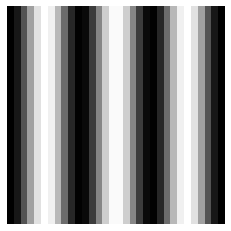

In [22]:
#from matplotlib import rc
rc('animation', html='jshtml')

# init figure
fig, ax = plt.subplots()

# function to update frames of the animation
def update(i):
  ax.imshow(stimulus[:,:,i],cmap='gray',extent=extents)
  ax.set_axis_off()

# setup the animation
anim = FuncAnimation(fig, update, frames=nTimePoints, interval=50)

# and display it
anim

Challenge question. 

Test the direction tuning of your motion-opponent energy model above, by changing the direction of the grating around 360 degrees. Remember that the output you are seeing is filters at every location in X and Y over the full time period of the stimulus. Extract the output averaged across space and time, so that you get a single number and plot as a function of direction. 

Try to make a moving plaid stimulus. A plaid is composed of two moving gratings of different orientations, say 0 degrees and 90 degrees. Display using the animation code above. Which direction does the plaid appear to be moving in? 

Now look at the tuning fucntion of your motion-opponent energy model as you make plaids moving in different directions around 360 degrees. What does the tuning function look like. Does it match your perception?

Is there a model that you can make that builds on the motion energy model that would produce a motion analysis that matches what you see?

Calculating direction tuning function: 100%|██████████| 360/360 [00:18<00:00, 19.17it/s]


<Figure size 432x288 with 0 Axes>

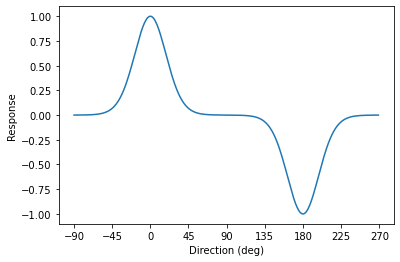

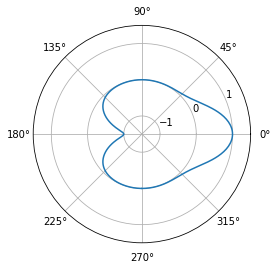

In [27]:
# first a little function to generate an orientation
# and temporal frequency that corresponds to whatever
# direction we want to present
def getDirParams(direction):
  # orientation goes only around 180 degrees
  orientation = np.mod(direction,180)
  # then tf will go positive for one direction
  # and negative for the other direction
  if (direction < 180) and (direction >= 0):
    tf = 1
  else:
    tf = -1
  # return the necessary orientation and tf to create the direction
  return orientation, tf

# init variables
rSum =[]
stimulus = np.zeros((meshsize,meshsize,nTimePoints))
dirStep = 1

# Cycle over directions and generate gratings
for iDirection in progressBar(range(-90,270,dirStep), desc="Calculating direction tuning function"):
  # get the orientation and tf that corresponds to this direction
  orientation, tf = getDirParams(iDirection)
  # create the stimulus
  for t in range(0,nTimePoints):
    stimulus[:,:,t] = makeGrating(x, y, orientation, tf * 360 * (t / nTimePoints), 3)
  
  # compute response of the motion energy model
  r = computeMotionEnergyModelResponse(m, stimulus)

  # get sum
  rSum.append(np.sum(r))

# normalize response to maximum
rSum = rSum / np.max(rSum)

# plot the tuning function
dir = np.array(range(-90,270,dirStep))

# plot as x/y plot
plt.figure()
figs, ax = plt.subplots()
plt.plot(dir,rSum)
ax.set_xticks(np.linspace(-90,270,9))
plt.xlabel('Direction (deg)')
plt.ylabel('Response')
plt.savefig('dirMotionEnergyResponse.pdf')

# plot as polar plot
plt.figure()
plt.polar(np.pi*dir/180,rSum)
plt.ylim(-1.5,1.5)
plt.yticks([-1, 0,1]);
plt.savefig('dirMotionEnergyResponsePolar.pdf')


Computing plaid stimulus: 100%|██████████| 320/320 [00:04<00:00, 67.65it/s]


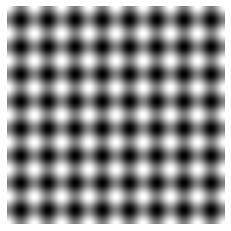

In [28]:
import cv2

# get x,y points to make stimuli
meshsize = 513
x, y, extents = getMeshPoints(meshsize)

# init output
fps = 30
image_size = (meshsize,meshsize)
out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'MP4V'), fps, image_size)

#init stimuli
grating1 = np.zeros((meshsize,meshsize,10*nTimePoints))
grating2 = np.zeros((meshsize,meshsize,10*nTimePoints))

# get the orientation and tf that corresponds to this direction
orientation, tf = getDirParams(0)
# generate the first grating at half contrast
for t in progressBar(range(0,10*nTimePoints),desc='Computing plaid stimulus'):
  grating1[:,:,t] = 0.5 * makeGrating(x, y, orientation, tf * 360 * (t / nTimePoints), 8)

# generate second grating
orientation, tf = getDirParams(90)
# generate the second grating at half contrast
for t in range(0,10*nTimePoints):
  grating2[:,:,t] = 0.5 * makeGrating(x, y, orientation, tf * 360 * (t / nTimePoints), 8)
  
# plaid is just the sum
plaid = grating1 + grating2

# init figure
fig, ax = plt.subplots()

# function to update frames of the animation
def update(i):
  ax.imshow(plaid[:,:,i],cmap='gray',extent=extents)
  ax.set_axis_off()

# setup the animation
anim = FuncAnimation(fig, update, frames=nTimePoints, interval=50)

# and display it
anim

Computing tuning curve: 100%|██████████| 360/360 [00:19<00:00, 18.40it/s]


<Figure size 432x288 with 0 Axes>

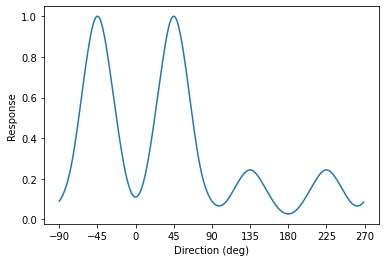

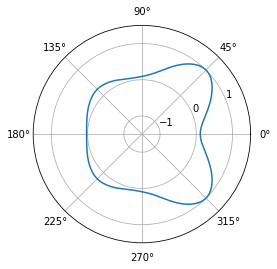

In [25]:
# get x,y points to make stimuli
meshsize = 32
x, y, extents = getMeshPoints(meshsize)

# Cycle over directions and generate plaids
rSum =[]
dirStep = 1
stimulus1 = np.zeros((meshsize,meshsize,nTimePoints))
stimulus2 = np.zeros((meshsize,meshsize,nTimePoints))
for iDirection in progressBar(range(-90,270,dirStep), desc='Computing tuning curve'):
  # get the orientation and tf that corresponds to this direction
  orientation, tf = getDirParams(iDirection-45)
  # generate the first grating at half contrast
  for t in range(0,nTimePoints):
    stimulus1[:,:,t] = 0.5 * makeGrating(x, y, orientation, tf * 360 * (t / nTimePoints), 3)
  # generate second grating
  orientation, tf = getDirParams(iDirection+45)
  # generate the second grating at half contrast
  for t in range(0,nTimePoints):
    stimulus2[:,:,t] = 0.5 * makeGrating(x, y, orientation, tf * 360 * (t / nTimePoints), 3)
  
  # compute response of the motion energy model
  r = computeMotionEnergyModelResponse(m, stimulus1+stimulus2)

  # get sum
  rSum.append(np.sum(r))

# normalize response to maximum
rSum = rSum / np.max(rSum)

# get direction array
dir = np.array(range(-90,270,dirStep))

# plot as x/y plot
plt.figure()
figs, ax = plt.subplots()
plt.plot(dir,rSum)
ax.set_xticks(np.linspace(-90,270,9))
plt.xlabel('Direction (deg)')
plt.ylabel('Response')
plt.savefig('plaidMotionEnergyResponse.pdf')

# plot as polar plot
plt.figure()
plt.polar(np.pi*dir/180,rSum)
plt.ylim(-1.5,1.5)
plt.yticks([-1, 0,1]);
plt.savefig('plaidMotionEnergyResponsePolar.pdf')
